In [ ]:
# The -q flag is for a "quiet" installation
!pip install -q segmentation-models-pytorch
!pip install -q pydicom
!pip install -q albumentations
!pip install -q kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.3 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata

# Get secrets
kaggle_username = userdata.get('KAGGLE_USERNAME')
kaggle_key = userdata.get('KAGGLE_KEY')

# Set environment variables for Kaggle API
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

# Create the Kaggle directory and the JSON file
!mkdir -p ~/.kaggle
!echo '{"username":"{os.environ["KAGGLE_USERNAME"]}","key":"{os.environ["KAGGLE_KEY"]}"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully!")

Kaggle API configured successfully!


In [ ]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge
!unzip -q rsna-pneumonia-detection-challenge.zip -d ./data

 99% 3.64G/3.66G [00:28<00:00, 256MB/s]
100% 3.66G/3.66G [00:28<00:00, 138MB/s]


In [ ]:
# List the contents of our new data directory to see what we have
!ls -lh ./data

total 5.2M
-rw-r--r-- 1 root root   55 Dec 11  2019 'GCP Credits Request Link - RSNA.txt'
-rw-r--r-- 1 root root 1.6M Dec 11  2019  stage_2_detailed_class_info.csv
-rw-r--r-- 1 root root 156K Dec 11  2019  stage_2_sample_submission.csv
drwxr-xr-x 2 root root 200K Jun 19 00:17  stage_2_test_images
drwxr-xr-x 2 root root 1.8M Jun 19 00:18  stage_2_train_images
-rw-r--r-- 1 root root 1.5M Dec 11  2019  stage_2_train_labels.csv


In [ ]:
import pandas as pd

# Define the path to our labels file
csv_path = './data/stage_2_train_labels.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Display the first 5 rows of the DataFrame
print("DataFrame Head:")
print(df.head())

print(f"\nTotal number of rows: {len(df)}")
print(f"Number of unique patients: {df['patientId'].nunique()}")

DataFrame Head:
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

Total number of rows: 30227
Number of unique patients: 26684


Visualizing Patient ID: 00aecb01-a116-45a2-956c-08d2fa55433f
Bounding Box: [x, y, width, height] = [547, 299, 119, 165]


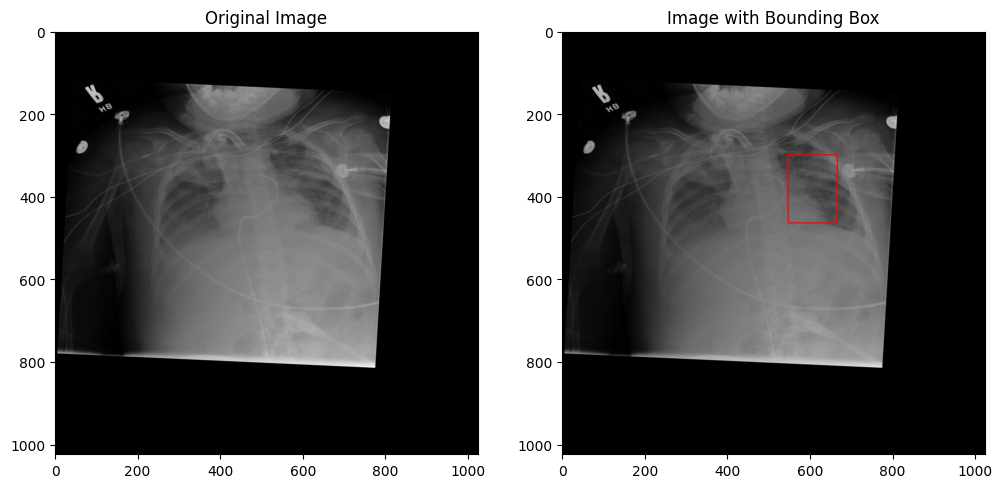

In [ ]:
import pydicom
import matplotlib.pyplot as plt
import cv2

# --- 1. Select a Sample with Pneumonia ---
# We filter the DataFrame to find rows where Target is 1
pneumonia_df = df[df['Target'] == 1]
sample_patient_info = pneumonia_df.iloc[5] # Let's pick the 6th patient with pneumonia

patient_id = sample_patient_info['patientId']
bbox = [
    int(sample_patient_info['x']),
    int(sample_patient_info['y']),
    int(sample_patient_info['width']),
    int(sample_patient_info['height'])
]

print(f"Visualizing Patient ID: {patient_id}")
print(f"Bounding Box: [x, y, width, height] = {bbox}")


# --- 2. Load the DICOM Image ---
dcm_file_path = f'./data/stage_2_train_images/{patient_id}.dcm'
dcm = pydicom.dcmread(dcm_file_path)

# The actual image data is in the 'pixel_array' attribute
image = dcm.pixel_array


# --- 3. Draw the Bounding Box on the Image ---
# We need to convert the grayscale image to a color image to draw a colored box
# COLOR_GRAY2BGR converts a 1-channel grayscale image to a 3-channel BGR image
image_with_box = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Unpack the bounding box coordinates
x, y, w, h = bbox
# Draw the rectangle
# Arguments: image, top-left corner, bottom-right corner, color (blue), thickness
cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 2)


# --- 4. Display the Images ---
# We will show the original and the one with the box side-by-side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Image with Bounding Box')
plt.imshow(image_with_box)

plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import pydicom
import numpy as np
import os

# We have all the necessary libraries already, so let's define the class.

class PneumoniaDataset(Dataset):
    """
    A custom PyTorch Dataset for the RSNA Pneumonia detection challenge.
    It reads a DICOM image and creates a corresponding segmentation mask
    from the bounding box coordinates in the labels CSV.
    """
    def __init__(self, data_dir, df, transform=None):
        """
        Args:
            data_dir (string): Directory with all the training images.
            df (pandas.DataFrame): The DataFrame containing the labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.df = df
        self.transform = transform

        # We get the unique patient IDs because one patient can have multiple
        # bounding box entries in the CSV. We want to load each image only once.
        self.patient_ids = df['patientId'].unique()

    def __len__(self):
        """Returns the total number of unique images."""
        return len(self.patient_ids)

    def __getitem__(self, idx):
        """
        Fetches the image and its mask for a given index.
        This is the core method where we:
        1. Load the image.
        2. Create a blank mask.
        3. "Paint" the pneumonia areas onto the mask using the bounding boxes.
        4. Apply transformations (like resizing and augmentation).
        5. Return the image and mask as tensors.
        """
        # 1. Load the image
        patient_id = self.patient_ids[idx]
        dcm_path = os.path.join(self.data_dir, f"{patient_id}.dcm")
        dcm = pydicom.dcmread(dcm_path)
        image = dcm.pixel_array

        # 2. Create the mask
        # Start with a black canvas (all zeros) of the same size as the original image
        mask = np.zeros_like(image, dtype=np.float32)

        # Find all rows in the dataframe that correspond to this patient
        patient_info = self.df[self.df['patientId'] == patient_id]

        # If the patient has pneumonia (Target=1), draw the bounding boxes on the mask
        if patient_info.iloc[0]['Target'] == 1:
            for _, row in patient_info.iterrows():
                # Extract coordinates
                x, y, w, h = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
                # "Paint" the rectangle on the mask with white pixels (value = 1)
                mask[y:y+h, x:x+w] = 1.0

        # Reshape for albumentations, which expects (H, W, Channels)
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        # 3. Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # 4. Convert to PyTorch tensors
        # Albumentations usually handles ToTensorV2, but if not, we do it manually.
        # The required format is (Channels, Height, Width)
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask = torch.from_numpy(mask).permute(2, 0, 1).float()

        return image, mask

print("PneumoniaDataset class defined successfully.")

PneumoniaDataset class defined successfully.


Image shape from dataset: torch.Size([1, 1024, 1024])
Mask shape from dataset: torch.Size([1, 1024, 1024])


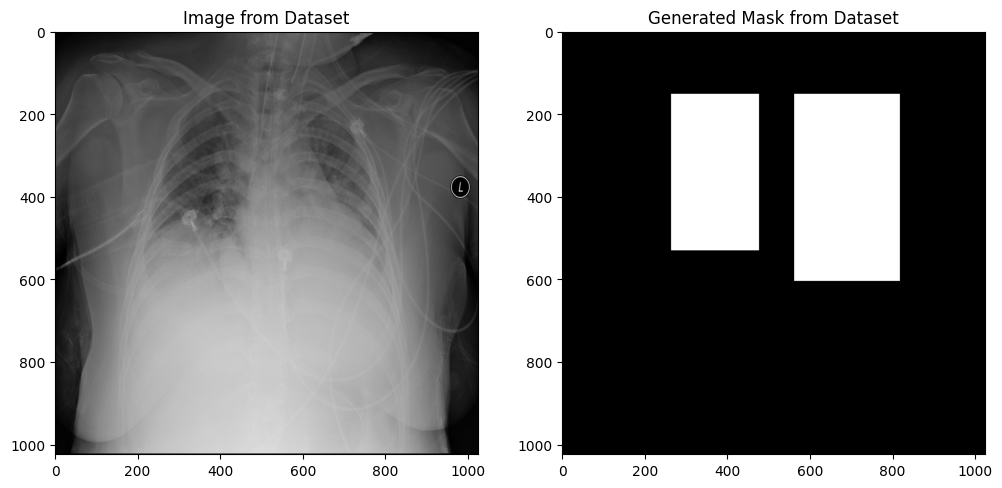

In [ ]:
import matplotlib.pyplot as plt

# We don't need augmentations for this test, just the raw data.
# We will use the 'df' DataFrame we loaded in the previous step.
# It should still be in memory.

# Create an instance of the dataset WITHOUT any transformations for now
verify_dataset = PneumoniaDataset(
    data_dir='./data/stage_2_train_images',
    df=df
)

# Let's get the same sample we visualized before
# Find the index for the patient we used in Step 5
# Note: This is just for a consistent example. Any index would work.
patient_id_to_find = '00436515-870c-4b36-a041-de91049b9ab4' # The ID from Step 5
patient_index = np.where(verify_dataset.patient_ids == patient_id_to_find)[0][0]


# Retrieve the image and the generated mask from our dataset
image, mask = verify_dataset[patient_index]

# The output of our dataset is a PyTorch tensor with shape (C, H, W).
# To display it with matplotlib, we need to change it to (H, W, C) or (H, W).
image_np = image.squeeze().numpy()
mask_np = mask.squeeze().numpy()

print(f"Image shape from dataset: {image.shape}")
print(f"Mask shape from dataset: {mask.shape}")

# Visualize the output
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Image from Dataset')
plt.imshow(image_np, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Generated Mask from Dataset')
plt.imshow(mask_np, cmap='gray')

plt.show()

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 # This converts numpy arrays to PyTorch tensors

# --- Configuration for Transformations ---
# We need to resize the images to a manageable size for the GPU.
# 256x256 is a good starting point.
IMAGE_SIZE = 256

# --- Define the Training Augmentation Pipeline ---
train_transform = A.Compose([
    # Resize the image to our desired size.
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),

    # Apply some common augmentations to make the model more robust.
    A.HorizontalFlip(p=0.5), # p=0.5 means it happens 50% of the time.
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),

    # We don't need ToTensorV2 because our dataset class will handle it,
    # but it's good practice to know about it. We will handle the conversion
    # inside the dataset class for clarity.
])

# --- Define the Validation Augmentation Pipeline ---
val_transform = A.Compose([
    # For validation, we ONLY resize. No random changes.
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
])

print("Albumentations transformation pipelines defined successfully.")

Albumentations transformation pipelines defined successfully.


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import pandas as pd

# Load the CSV again if needed, though it should be in memory as 'df'
# csv_path = './data/stage_2_train_labels.csv'
# df = pd.read_csv(csv_path)

# --- 1. Split Patient IDs ---
# Get a list of unique patient IDs
patient_ids = df['patientId'].unique()

# Use scikit-learn to split the patient IDs into training and validation sets
# A 90/10 split is common. random_state ensures the split is the same every time.
train_ids, val_ids = train_test_split(patient_ids, test_size=0.1, random_state=42)

print(f"Number of training patients: {len(train_ids)}")
print(f"Number of validation patients: {len(val_ids)}")


# --- 2. Create DataFrames for Each Set ---
# Filter the main DataFrame to create one for training and one for validation
train_df = df[df['patientId'].isin(train_ids)]
val_df = df[df['patientId'].isin(val_ids)]


# --- 3. Create Dataset Instances ---
# Now we pass our augmentation pipelines to our dataset class
train_dataset = PneumoniaDataset(
    data_dir='./data/stage_2_train_images',
    df=train_df,
    transform=train_transform
)

val_dataset = PneumoniaDataset(
    data_dir='./data/stage_2_train_images',
    df=val_df,
    transform=val_transform
)

print(f"\nNumber of samples in training set: {len(train_dataset)}")
print(f"Number of samples in validation set: {len(val_dataset)}")


# --- 4. Create DataLoaders ---
BATCH_SIZE = 16 # Number of samples per batch. Adjust based on GPU memory.

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Shuffle the training data each epoch
    num_workers=2, # Use multiple subprocesses to load data. 2 is good for Colab.
    pin_memory=True # Speeds up data transfer to the GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=2,
    pin_memory=True
)

print(f"\nDataLoaders created. Training batch size: {BATCH_SIZE}")

# --- Optional: Verify a Batch ---
# Let's check if we can pull one batch from the train_loader
images, masks = next(iter(train_loader))
print(f"Shape of one batch of images: {images.shape}") # Should be [BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE]
print(f"Shape of one batch of masks: {masks.shape}")   # Should be [BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE]

Number of training patients: 24015
Number of validation patients: 2669

Number of samples in training set: 24015
Number of samples in validation set: 2669

DataLoaders created. Training batch size: 16
Shape of one batch of images: torch.Size([16, 1, 256, 256])
Shape of one batch of masks: torch.Size([16, 1, 256, 256])


In [ ]:
import segmentation_models_pytorch as smp
import torch

# --- 1. Define the Model ---
# We are using the U-Net architecture from the SMP library.

model = smp.Unet(
    encoder_name="efficientnet-b4",  # <-- Use a more powerful, modern backbone
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation='sigmoid'
)
model.to(DEVICE)

# --- 2. Move the Model to the GPU ---
# We need to tell PyTorch to run the model on the GPU we enabled in Colab.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

# --- 3. Print a Model Summary (Optional but Recommended) ---
# This gives you a look at the model's architecture. It can be long!
# You can try using the torchinfo library for a cleaner summary if you want.
# !pip install -q torchinfo
# from torchinfo import summary
# summary(model, input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE))

print(f"Model created and moved to device: {DEVICE}")
print(f"Model Architecture: U-Net with a ResNet-34 encoder.")

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Model created and moved to device: cuda
Model Architecture: U-Net with a ResNet-34 encoder.


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4


# --- THE CORRECTED LOSS FUNCTION ---
# We define a custom class to handle the weighted combination of losses.
# This is the standard and robust PyTorch way to create a composite loss.
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=1.0, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, y_pred, y_true):
        # Calculate each loss component on the tensors
        dice = self.dice_loss(y_pred, y_true)
        bce = self.bce_loss(y_pred, y_true)

        # Return the weighted sum of the calculated loss values
        return (self.dice_weight * dice) + (self.bce_weight * bce)

# Create an instance of our custom combined loss function
loss_fn = CombinedLoss()

# --- Optimizer ---
# This definition remains the same.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Learning Rate Scheduler ---
# This definition also remains the same.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

print("✅ Model, Loss, Optimizer, and Scheduler defined.")
print(f"   Device: {DEVICE}")
print(f"   Model: U-Net with EfficientNet-B4 backbone")
print(f"   Loss Function: Custom CombinedLoss (Weighted Dice + BCE)")

✅ Model, Loss, Optimizer, and Scheduler defined.
   Device: cuda
   Model: U-Net with EfficientNet-B4 backbone
   Loss Function: Custom CombinedLoss (Weighted Dice + BCE)


In [ ]:
from tqdm.notebook import tqdm # Use the notebook-friendly version of tqdm for a nice progress bar
import time

# --- Configuration for Training ---
EPOCHS = 20

# --- Begin Training ---
# We will store the loss history to plot it later
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf') # Initialize with a very high value

# Get the device name for printing
device_name = torch.cuda.get_device_name(0) if DEVICE == "cuda" else "CPU"
print(f"Starting training on {device_name} for {EPOCHS} epochs...\n")

for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"--- Epoch {epoch+1}/{EPOCHS} ---")

    # --- Training Phase ---
    model.train()
    train_loss = 0.0

    # Using tqdm for a progress bar
    train_progress_bar = tqdm(train_loader, desc="Training")

    for images, masks in train_progress_bar:
        # Move data to the GPU
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        # 1. Forward pass
        outputs = model(images)

        # 2. Calculate loss
        loss = loss_fn(outputs, masks)

        # 3. Backward pass and optimization
        optimizer.zero_grad() # Clear old gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update model weights

        train_loss += loss.item()
        train_progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0

    # No need to track gradients during validation
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc="Validation")
        for images, masks in val_progress_bar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            outputs = model(images)
            loss = loss_fn(outputs, masks)

            val_loss += loss.item()
            val_progress_bar.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)

    end_time = time.time()
    epoch_duration = time.strftime("%M:%S", time.gmtime(end_time - start_time))

    # --- Print Epoch Summary ---
    print(f"Epoch {epoch+1} Summary | Duration: {epoch_duration}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # --- Save the Best Model ---
    # We save the model if the current validation loss is the best we've seen so far.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  -> New best model saved! Validation loss improved to {best_val_loss:.4f}\n")
    else:
        print("\n")

print("="*30)
print("          TRAINING COMPLETE")
print(f"Best validation loss achieved: {best_val_loss:.4f}")
print("The best model has been saved as 'best_model.pth'")
print("="*30)

Starting training on Tesla T4 for 20 epochs...

--- Epoch 1/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 1 Summary | Duration: 10:32
  Train Loss: 1.2927 | Val Loss: 1.2582
  -> New best model saved! Validation loss improved to 1.2582

--- Epoch 2/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 2 Summary | Duration: 10:30
  Train Loss: 1.2687 | Val Loss: 1.2554
  -> New best model saved! Validation loss improved to 1.2554

--- Epoch 3/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 3 Summary | Duration: 10:31
  Train Loss: 1.2725 | Val Loss: 1.2553
  -> New best model saved! Validation loss improved to 1.2553

--- Epoch 4/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 4 Summary | Duration: 10:31
  Train Loss: 1.2694 | Val Loss: 1.2559


--- Epoch 5/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 5 Summary | Duration: 10:32
  Train Loss: 1.2660 | Val Loss: 1.2557


--- Epoch 6/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 6 Summary | Duration: 10:33
  Train Loss: 1.2687 | Val Loss: 1.2548
  -> New best model saved! Validation loss improved to 1.2548

--- Epoch 7/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 7 Summary | Duration: 10:35
  Train Loss: 1.2674 | Val Loss: 1.2555


--- Epoch 8/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 8 Summary | Duration: 10:32
  Train Loss: 1.2697 | Val Loss: 1.2558


--- Epoch 9/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 9 Summary | Duration: 10:33
  Train Loss: 1.2697 | Val Loss: 1.2560


--- Epoch 10/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 10 Summary | Duration: 10:32
  Train Loss: 1.2657 | Val Loss: 1.2568


--- Epoch 11/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 11 Summary | Duration: 10:33
  Train Loss: 1.2687 | Val Loss: 1.2560


--- Epoch 12/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 12 Summary | Duration: 10:32
  Train Loss: 1.2707 | Val Loss: 1.2567


--- Epoch 13/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 13 Summary | Duration: 10:32
  Train Loss: 1.2630 | Val Loss: 1.2564


--- Epoch 14/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 14 Summary | Duration: 10:32
  Train Loss: 1.2620 | Val Loss: 1.2559


--- Epoch 15/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 15 Summary | Duration: 10:32
  Train Loss: 1.2639 | Val Loss: 1.2560


--- Epoch 16/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

Validation:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 16 Summary | Duration: 10:33
  Train Loss: 1.2674 | Val Loss: 1.2581


--- Epoch 17/20 ---


Training:   0%|          | 0/1501 [00:00<?, ?it/s]

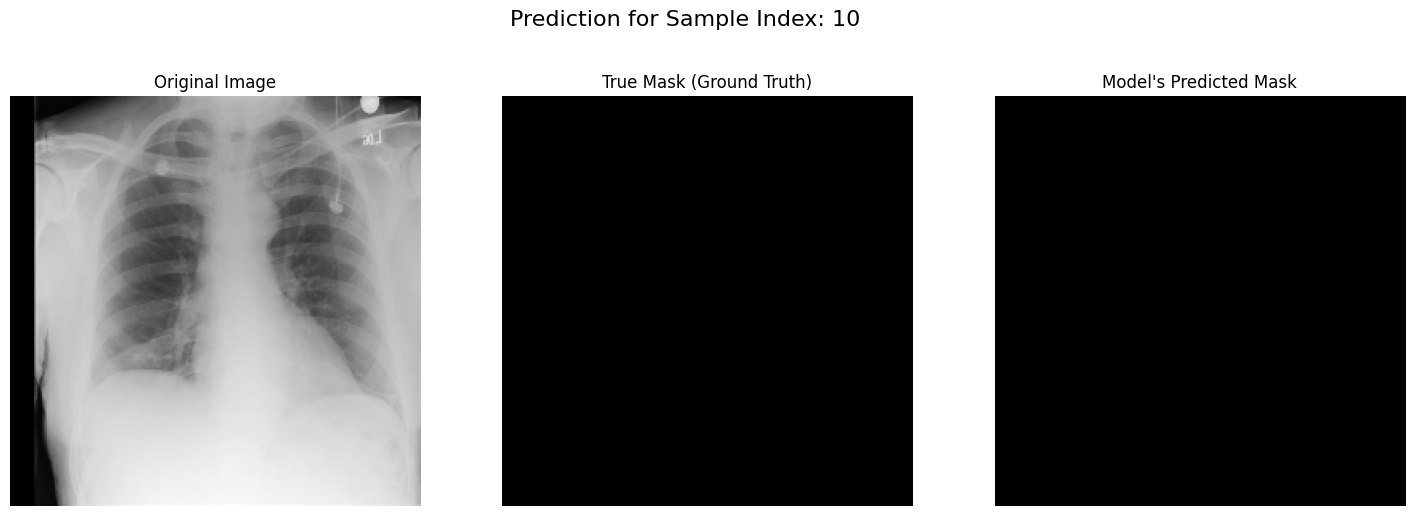

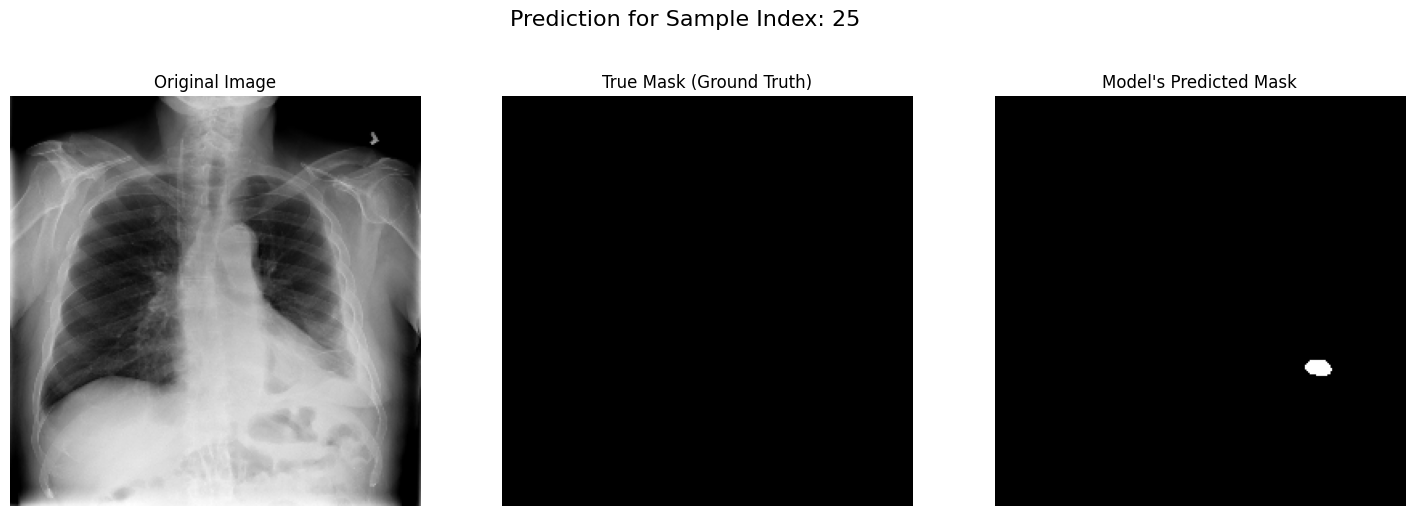

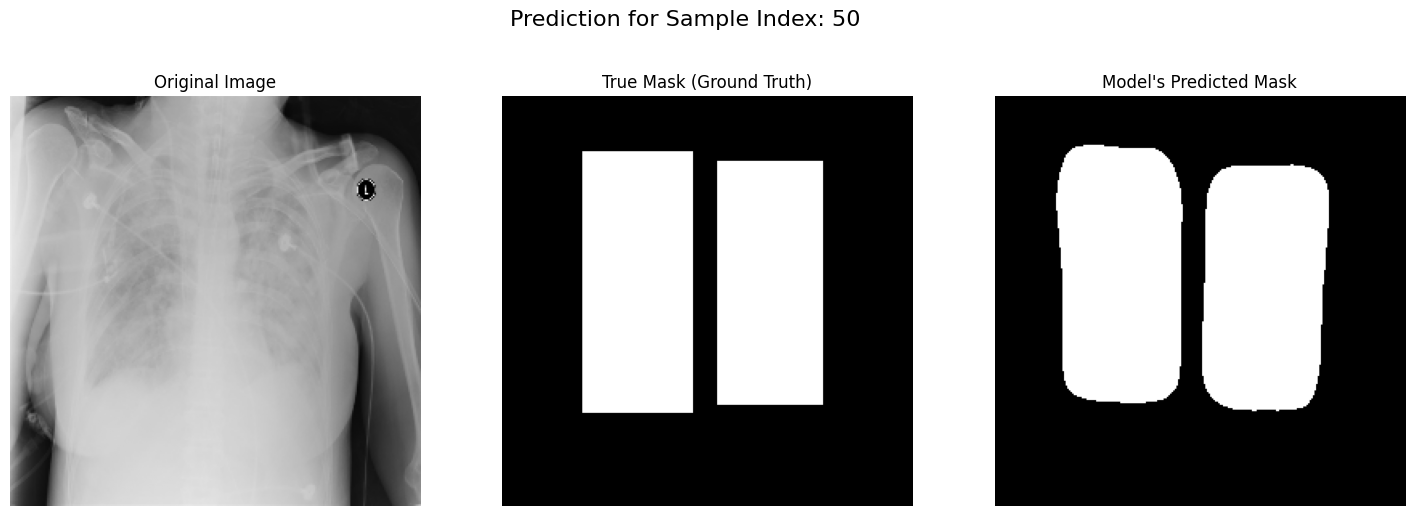

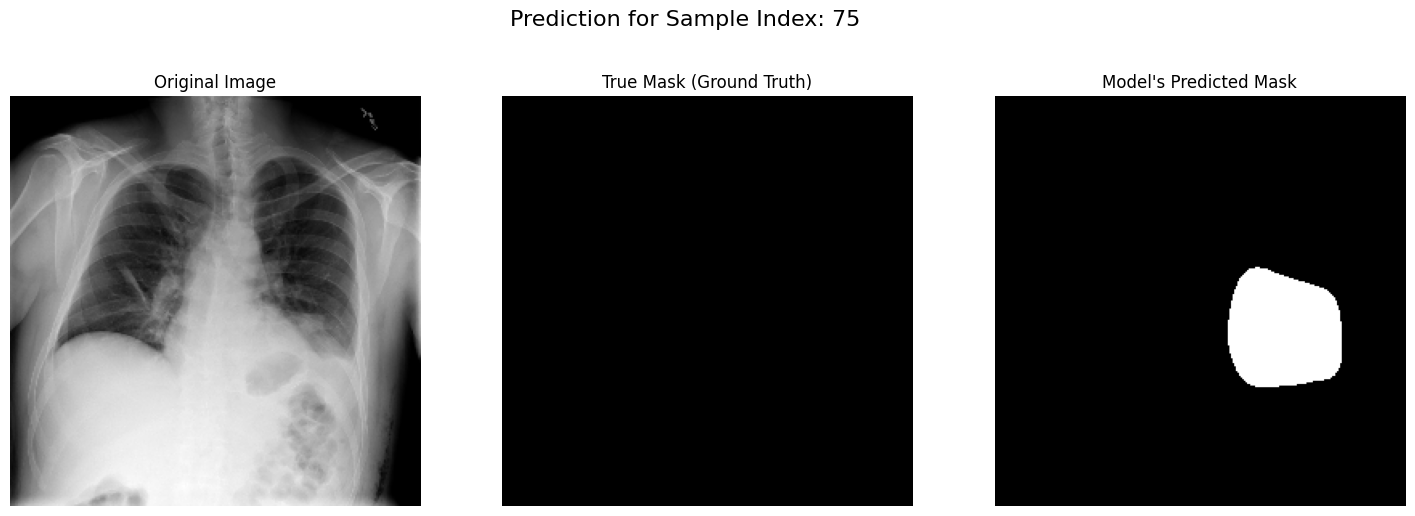

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import segmentation_models_pytorch as smp

# --- 1. Configuration ---
MODEL_PATH = 'best_model.pth'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 2. Re-create the Model and Load Weights ---
# It's crucial to define the model architecture exactly as we did for training.
model = smp.Unet("resnet34", in_channels=1, classes=1, activation='sigmoid')
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE)
model.eval() # Set the model to evaluation mode

# --- 3. Get a Sample from the Validation Set ---
# We already have val_dataset and val_loader in memory from the previous steps.
# Let's get a few samples to see how it does on different cases.
def visualize_predictions(sample_indices):
    for i, sample_idx in enumerate(sample_indices):
        # Retrieve the image and the true mask
        image, true_mask = val_dataset[sample_idx]

        # --- 4. Make a Prediction ---
        with torch.no_grad(): # Disable gradient calculation for inference
            # Add a batch dimension (B, C, H, W) and send to the GPU
            input_image = image.unsqueeze(0).to(DEVICE)

            # Get the model's raw output
            pred_mask_raw = model(input_image)

            # Process the output:
            # 1. Remove the batch dimension with .squeeze()
            # 2. Move the tensor from GPU to CPU with .cpu()
            # 3. Convert to a NumPy array with .numpy()
            # 4. Apply a threshold of 0.5 to get a binary mask (0s and 1s)
            pred_mask = (pred_mask_raw.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

        # --- 5. Visualize the Results ---
        # Convert original image and true_mask tensors to displayable NumPy arrays
        original_image = image.squeeze().numpy()
        true_mask_np = true_mask.squeeze().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'Prediction for Sample Index: {sample_idx}', fontsize=16)

        ax[0].imshow(original_image, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(true_mask_np, cmap='gray')
        ax[1].set_title('True Mask (Ground Truth)')
        ax[1].axis('off')

        ax[2].imshow(pred_mask, cmap='gray')
        ax[2].set_title('Model\'s Predicted Mask')
        ax[2].axis('off')

        plt.show()

# --- Pick some sample indices to check ---
# It's good to try a few to get a feel for the model's performance.
sample_indices_to_check = [10, 25, 50, 75]
visualize_predictions(sample_indices_to_check)